In [52]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing import image  
import cv2
import string

In [53]:
src_path=r'/input/uda_MER'
img_path=os.path.join(src_path,'train')
csv_file=pd.read_csv(os.path.join(src_path,'train.csv'))
# img path and label
paths=[i for i in csv_file['filename']] 
labels=[i for i in csv_file['label']]

In [54]:
#define characters in the expression
chars = '0123456789+-*()=' 
chars_array = np.array(list(chars))

#
n_class = len(chars)+1
#Max length of the expression
len_label=[len(i) for i in labels]
len_label.sort()
n_seq=len_label[-1]
min_seq=len_label[0]
print('Max.Len={}'.format(n_seq))
print('Min.Len={}'.format(min_seq))
#

Max.Len=11
Min.Len=7


In [55]:
#split the data set, get 100000 test data 
img_path_rest, img_path_test, labels_rest, labels_test = train_test_split(paths, labels, test_size=10000, random_state=10)
#split the data set, get 100000 valid data
img_path_train, img_path_valid, labels_train, labels_valid = train_test_split(img_path_rest, labels_rest, test_size=10000, random_state=10)
print(len(img_path_train),len(img_path_valid),len(img_path_test))
print(img_path_train[0])
print('Example of path: {}'.format(img_path_train[0]))
print('Example of label: {}'.format(labels_train[0]))
#should be updated

80000 10000 10000
train/31546.jpg
Example of path: train/31546.jpg
Example of label: 7*(6-5)=7


In [58]:
#get label length
def get_label_len(labels):
    length=np.zeros((len(labels),1))
    for i,label in enumerate(labels):
        length[i] = len(label)
    return length

#turn a path list into numpy array
def tensors_trans(paths):
    img_list=[]
    for element in paths:
        ele=os.path.join(src_path,element)
        img=cv2.imread(ele)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = np.expand_dims(image.img_to_array(img_gray),axis=0)
        img_list.append(img_gray)
    img_tensor=np.vstack(img_list)
    return img_tensor
#label to index reffers to chars
def get_index(label):
    index = np.zeros(n_seq)
    for i, char in enumerate(label):
        index[i] = chars.find(char)
    return index

In [60]:
#maybe ues the iterator will be better
X_train, X_valid, X_test = [tensors_trans(img_path) for img_path in [img_path_train, img_path_valid, img_path_test]]
y_train = np.array([get_index(label) for label in labels_train])
y_valid = np.array([get_index(label) for label in labels_valid])
y_test = np.array([get_index(label) for label in labels_test])

In [61]:
label_length_train = get_label_len(labels_train)
label_length_valid = get_label_len(labels_valid)
label_length_test = get_label_len(labels_test)

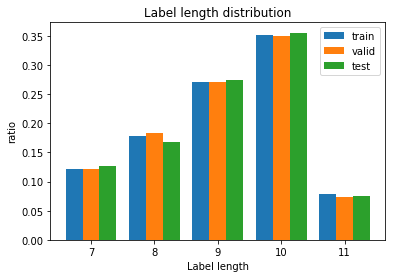

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot();
plt.hist(x=[label_length_train,label_length_valid,label_length_test],
         bins=[7,8,9,10,11,12],align='left',density=1,);
plt.title('Label length distribution');
plt.legend(['train','valid','test']);
plt.xlabel('Label length');
plt.ylabel('ratio');

In [14]:
h = cv2.equalizeHist(gray)


In [ ]:
show_pic(img_path_train[0],labels_train[0])

In [63]:
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.regularizers import L1L2
import matplotlib.pyplot as plt
import re
from keras.callbacks import *
from keras.optimizers import SGD
%matplotlib inline

In [64]:
height, width, channel = X_train.shape[1:]
input_tensor = Input(shape=[height, width, channel])
x = input_tensor

x = Conv2D(32*2**0, 3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal')(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(32*2**1, 3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal')(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(32*2**2, 3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal')(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)
x = Dropout(rate=0.25)(x)
x = Conv2D(256, 3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(x)

x = Conv2D(512, 3, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001)(x)

x = MaxPooling2D((1, 2), strides=2, padding='same')(x)
x = Dropout(rate=0.5)(x)

x = Permute((2,1,3))(x)

x = TimeDistributed(Flatten())(x)

x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)

y_pred = Dense(n_class,activation='softmax')(x)

base_model = Model(inputs=input_tensor,outputs = y_pred)

In [65]:
chars_space = chars + u' '#unicode
def decode(pred):
    pred = pred.argmax(axis=2)#get the most possible char
    orig_labels = []
    new_labels = []
    for i, code in enumerate(pred):
        orig_labels.append(''.join([chars_space[x] for x in code]))
    for string in orig_labels:
        new_labels.append(re.sub(r'\s','',re.sub(r'(.)\1+', r'\1', string)))#remove uncessary space and ```                              
    return [np.array(orig_labels), np.array(new_labels)]

In [66]:
def evalute_valid(model):
    pred = model.predict(X_valid)
    org_labels, new_labels = decode(pred)
    return (new_labels==labels_valid).mean()*100#valid data set accuracy

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evalute_valid(base_model)
        self.accs.append(acc)
        print('valid acc: %f%%'%acc)

evaluator = Evaluate()

In [67]:
#  CTC-Loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
labels = Input(name='the_labels', shape=[None], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')# 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 64, 300, 32)  320         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 32, 150, 32)  0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32, 150, 32)  0           max_pooling2d_28[0][0]           
__________________________________________________________________________________________________
conv2d_72 

In [68]:
model_file_path = '/output/model01.hd5'#weight file

#base_model.load_weights(model_file_path)

In [69]:
checkpointer = ModelCheckpoint(filepath=model_file_path, 
                               verbose=1, monitor='val_loss', save_best_only=True)
esp = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tb = TensorBoard(log_dir='./output', update_freq='epoch')

#
input_len_to_ctc = np.array(np.ones((len(X_train),1))*base_model.output_shape[1])
label_len_to_ctc = label_length_train

input_len_to_ctc2 = np.array(np.ones((len(X_valid),1))*base_model.output_shape[1])
label_len_to_ctc2 = label_length_valid


fited = model.fit(x=[X_train, y_train, input_len_to_ctc, label_len_to_ctc], 
                  y=np.ones(len(y_train)),
                  validation_data=([X_valid, y_valid, input_len_to_ctc2, label_len_to_ctc2], np.ones(len(y_valid))),
                  batch_size=200, epochs=400, callbacks=[checkpointer, evaluator, esp, tb], verbose=1)

Train on 80000 samples, validate on 10000 samples
Epoch 1/400
80000/80000 [==============================] - 114s 1ms/step - loss: 13.0448 - val_loss: 39.5771

Epoch 00001: val_loss improved from inf to 39.57708, saving model to /output/model01.hd5
valid acc: 0.000000%
Epoch 2/400
80000/80000 [==============================] - 114s 1ms/step - loss: 1.1339 - val_loss: 0.5028

Epoch 00002: val_loss improved from 39.57708 to 0.50276, saving model to /output/model01.hd5
valid acc: 89.570000%
Epoch 3/400
80000/80000 [==============================] - 114s 1ms/step - loss: 0.5184 - val_loss: 0.2570

Epoch 00003: val_loss improved from 0.50276 to 0.25700, saving model to /output/model01.hd5
valid acc: 94.510000%
Epoch 4/400
80000/80000 [==============================] - 114s 1ms/step - loss: 0.3516 - val_loss: 0.2008

Epoch 00004: val_loss improved from 0.25700 to 0.20075, saving model to /output/model01.hd5
valid acc: 95.740000%
Epoch 5/400
80000/80000 [==============================] - 114s


Epoch 00041: val_loss improved from 0.03413 to 0.03396, saving model to /output/model01.hd5
valid acc: 99.090000%
Epoch 42/400
80000/80000 [==============================] - 114s 1ms/step - loss: 0.0485 - val_loss: 0.0549

Epoch 00042: val_loss did not improve from 0.03396
valid acc: 98.630000%
Epoch 43/400
80000/80000 [==============================] - 114s 1ms/step - loss: 0.0421 - val_loss: 0.0461

Epoch 00044: val_loss did not improve from 0.02951
valid acc: 99.190000%
Epoch 45/400
80000/80000 [==============================] - 112s 1ms/step - loss: 0.0442 - val_loss: 0.0362

Epoch 00045: val_loss did not improve from 0.02951
valid acc: 99.130000%
Epoch 46/400
80000/80000 [==============================] - 109s 1ms/step - loss: 0.0443 - val_loss: 0.0372

Epoch 00046: val_loss did not improve from 0.02951
valid acc: 99.210000%
Epoch 47/400
80000/80000 [==============================] - 114s 1ms/step - loss: 0.0463 - val_loss: 0.0463

Epoch 00047: val_loss did not improve from 0.029

In [70]:
base_model.load_weights(model_file_path)
pred = base_model.predict(X_test)
sequence, new_labels = decode(pred)
test_acc = (new_labels==labels_test).mean()*100
print('test_acc: {}%'.format(round(test_acc,2)))
#1round acc:98.09%
#2round acc:97.05%
#```
#finial

test_acc: 99.26%


In [72]:
model.save('model')

dict_keys(['val_loss', 'loss'])


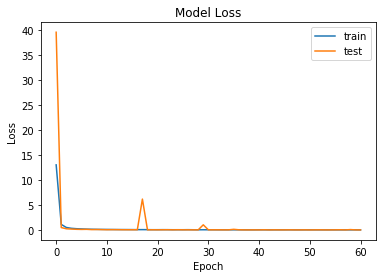

In [73]:
print(fited.history.keys())
# loss during the training process
plt.plot(fited.history['loss'])
plt.plot(fited.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

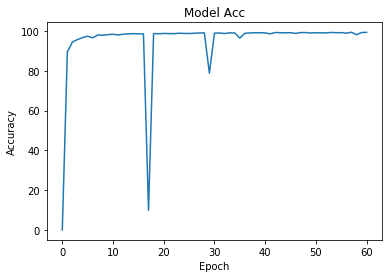

In [74]:
acc = evaluator.accs
plt.plot(acc)
plt.title('Model Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print(img_path_test[:3])
print(sequence[:3])
print(new_labels[:3])